In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('2012_public_use_data_aug2016.csv')
print(df.shape)
df.dtypes

(6720, 1119)


PUBID        int64
REGION       int64
CENDIV       int64
PBA          int64
FREESTN    float64
            ...   
DHCLBTU    float64
DHWTBTU    float64
DHCKBTU    float64
DHOTBTU    float64
PUBCLIM      int64
Length: 1119, dtype: object

In [3]:
df.sample(5)

,PUBID,REGION,CENDIV,PBA,FREESTN,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,FKCLBTU,FKWTBTU,FKCKBTU,FKOTBTU,DHHTBTU,DHCLBTU,DHWTBTU,DHCKBTU,DHOTBTU,PUBCLIM
6592,6593,3,7,26,1.0,40000,5,3,4,2,...,0.0,0.0,0.0,99533.0,603111.0,10826288.0,128601.0,0.0,0.0,3
3882,3883,4,8,25,1.0,1450,2,1,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5632,5633,2,4,5,1.0,290000,8,2,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
640,641,1,2,18,1.0,430000,8,1,6,2,...,NaN,NaN,NaN,NaN,6908606.0,7568047.0,17459347.0,0.0,0.0,2
874,875,3,5,2,1.0,10250,4,1,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [4]:
# update with new codebook created from "clean_cbecs2012_codebook.ipynb"
df_codebook = pd.read_csv('2012cbecs_codebook_wDicts.csv')
df_codebook.head()

,category,file_order,col_name,col_type,length,format,col_description,codes,codes_dict
0,0,1.0,PUBID,Char,5.0,NaN,Building identifier,00001 - 06720,{'00001 - 06720': 'continuous numerical range'}
1,0,2.0,REGION,Char,1.0,$REGION.,Census region,'1' = 'Northeast'\n'2' = 'Midwest'\n'3' = 'Sou...,"{'1': 'Northeast', '2': 'Midwest', '3': 'South..."
2,0,3.0,CENDIV,Char,1.0,$CENDIV.,Census division,'1' = 'New England'\n'2' = 'Middle Atlantic'\n...,"{'1': 'New England', '2': 'Middle Atlantic', '..."
3,0,4.0,PBA,Char,2.0,$PBA.,Principal building activity,'01' = 'Vacant'\n'02' = 'Office'\n'04' = 'Labo...,"{'01': 'Vacant', '02': 'Office', '04': 'Labora..."
4,1,5.0,FREESTN,Char,1.0,$YES.,Freestanding building,1' = 'Yes'\nMissing='No',"{'1': 'Yes', 'Missing': 'No'}"


In [5]:
print(df_codebook.category.unique())

[ 0  1  2  3  4  5  6  7 10]


In [6]:
category_map = {}
for cat in df_codebook.category.unique():
    category_cols_df = df_codebook[df_codebook['category'] == cat]
    cat_cols = []
    for col in category_cols_df.col_name.values:
        if type(col) == str:
            cat_cols.append(col)
    category_map[cat] = cat_cols

In [7]:
keep_cols = []
for wanted_cols in category_map.values():
    for col in wanted_cols:
        keep_cols.append(col)
print(len(keep_cols))

516


## EDA

Separated by Category (1-7, 10)

In [8]:
def build_hist(column_list):
    figname = 0
    for column in column_list:
        plt.figure(figname)
        sns.set(rc = {'figure.figsize':(2,2)})
        sns.histplot(data=df, x=column, kde=True)
        figname += 1

In [9]:
df = df[keep_cols]
print(df.shape)
df.sample(5)

(6720, 516)


,PUBID,REGION,CENDIV,PBA,FREESTN,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,FKCLBTU,FKWTBTU,FKCKBTU,FKOTBTU,DHHTBTU,DHCLBTU,DHWTBTU,DHCKBTU,DHOTBTU,PUBCLIM
6429,6430,3,7,5,1.0,4050,2,5,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3454,3455,3,5,5,1.0,124000,7,1,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4616,4617,2,3,26,1.0,2550,2,3,5,2,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2
3805,3806,4,9,23,1.0,44500,5,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4472,4473,4,8,24,1.0,1500000,10,1,6,1,...,0.0,0.0,0.0,4073969.0,NaN,NaN,NaN,NaN,NaN,7


In [10]:
## Adjusting for weird values

df.NFLOOR.replace(to_replace=994, value=20, inplace=True)
df.NFLOOR.replace(to_replace=995, value=26, inplace=True)
df.FLCEILHT.replace(to_replace=995, value=51, inplace=True)
df.NELVTR.replace(to_replace=995, value=51, inplace=True)
df.NESLTR.replace(to_replace=995, value=21, inplace=True)
df.YRCON.replace(to_replace=995, value=1945, inplace=True)
df.RWSEAT.replace(to_replace=99995, value=15001, inplace=True)
df.PBSEAT.replace(to_replace=999995, value=15001, inplace=True)
df.HCBED.replace(to_replace=9995, value=251, inplace=True)
df.NRSBED.replace(to_replace=9995, value=251, inplace=True)
df.LODGRM.replace(to_replace=99995, value=901, inplace=True)
df.NOCC.replace(to_replace=995, value=201, inplace=True)
df.ELLUPCT.replace(to_replace=999, value=None, inplace=True)
df.WOEXP.replace(to_replace=999999, value=None, inplace=True)
df.XRAYN.replace(to_replace=995, value=21, inplace=True)
df.RFGCOMPN.replace(to_replace=99995, value=1001, inplace=True)
df.TVVIDEON.replace(to_replace=995, value=201, inplace=True)

In [11]:
category_map[0]

['PUBID', 'REGION', 'CENDIV', 'PBA']

In [12]:
category_dfs = {}
for cat_name, cat_list in category_map.items():
    category_dfs[cat_name] = df[cat_list]
category_dfs[0].sample(10)

,PUBID,REGION,CENDIV,PBA
3395,3396,4,9,26
6577,6578,3,5,2
2311,2312,1,2,8
1535,1536,1,2,5
3139,3140,3,5,23
3561,3562,1,2,12
3429,3430,2,4,16
4420,4421,1,2,5
165,166,4,8,13
5924,5925,3,5,5


In [13]:
codebook_test = df_codebook.copy().set_index('col_name')
num_cols = []
for col in codebook_test.index:
    if codebook_test.loc[col].col_type == 'Num':
        num_cols.append(col)

### EDA Category 1

Building Attributes - tried to select only continuous variables
1. Square Footage (SQFT) 1,001 - 1,500,000
2. Number of Floors (NFLOOR) 1-14, 994=15-25, 995= >25
3. Year of construction (YRCON) 995=<1946, 1946-2012
4. Any Renovations (RENOV) 1=yes, 2=no

Total Size n = 6720

Grouped by Rennovation status (`NFLOOR`, `SQFT`, `YRCON`) 
- RENOV = 1 
    - n = 3423
    - mean = 47.776220	173371.279287	1826.157172
    - median = 2	42000	1974
    - std = 206.210635	310598.178086	355.687342
- RENOV = 2 
    - n = 2936
    - mean = 11.026226	70129.489441	1883.572548
    - median = 1	10750	1985
    - std = 94.754694	174537.161246	301.333128
- RENOV Missing
    - n = 361
    
Visualizations
- I need to do some more precise manipulation to get a better idea of the spread of the data (i.e. having a hard time visualizing num floors and year constructed due to the flagged variables (994/995)

General Thoughts
- Roughly even distribution of unrennovated/rennovated buildings
- Coded data throws off averages, so better to use medians
- Older buildings without rennovations are larger (sqft/numfloor)
- Younger buildings with rennovations are smaller (sqft/numfloor)

In [14]:
category_dfs[1].shape

(6720, 69)

In [15]:
num_cols_cat1 = []
for col in category_dfs[1].columns:
    #print(category_dfs[1][col].dtype)
    if col in num_cols:
        num_cols_cat1.append(col)
print(num_cols_cat1)

['SQFT', 'NFLOOR', 'BASEMNT', 'FLCEILHT', 'NELVTR', 'NESLTR', 'YRCON', 'ACT1PCT', 'ACT2PCT', 'ACT3PCT', 'RWSEAT', 'PBSEAT', 'EDSEAT', 'FDSEAT', 'HCBED', 'NRSBED', 'LODGRM']


In [16]:
df1 = category_dfs[1].copy()[num_cols_cat1]
df1_total = df1.shape[0]
print(df1_total)

6720


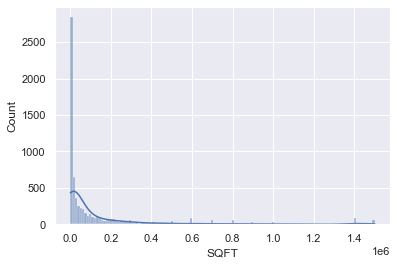

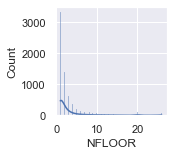

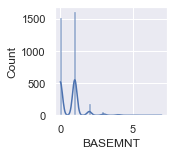

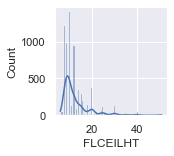

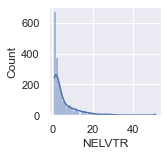

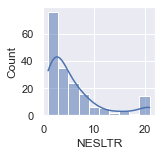

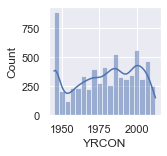

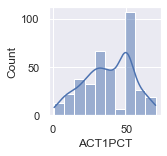

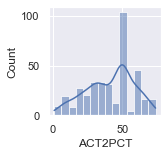

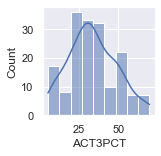

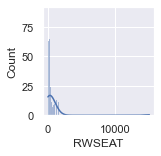

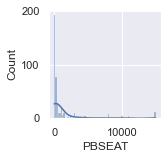

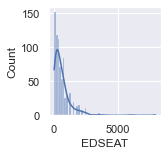

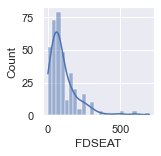

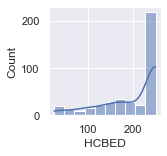

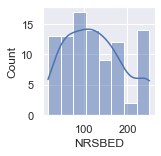

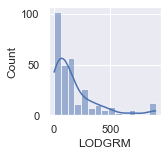

In [19]:
build_hist(num_cols_cat1)

### EDA Category 2

Building Ownership - Not now

In [20]:
num_cols_cat2 = []
for col in category_dfs[2].columns:
    if col in num_cols:
        num_cols_cat2.append(col)
print(num_cols_cat2)

df2 = category_dfs[2].copy()[num_cols_cat2]
df2_total = df2.shape[0]
print(df2_total)

['NOCC']
6720


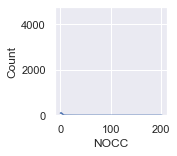

In [21]:
build_hist(num_cols_cat2)

### EDA Category 3

Operations

In [22]:
num_cols_cat3 = []
for col in category_dfs[3].columns:
    if col in num_cols:
        num_cols_cat3.append(col)
print(num_cols_cat3)

df3 = category_dfs[3].copy()[num_cols_cat3]
df3_total = df3.shape[0]
print(df3_total)

['MONUSE', 'OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER']
6720


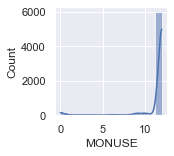

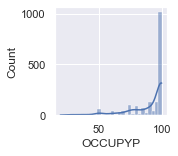

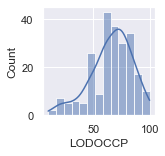

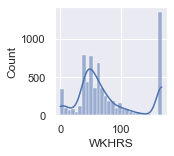

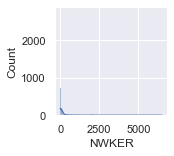

In [23]:
build_hist(num_cols_cat3)

### EDA Category 4

Energy Source / Purpose

In [24]:
num_cols_cat4 = []
for col in category_dfs[4].columns:
    if col in num_cols:
        num_cols_cat4.append(col)
print(num_cols_cat4)

df4 = category_dfs[4].copy()[num_cols_cat4]
df4_total = df4.shape[0]
print(df4_total)

['HEATP', 'FURNP', 'PKGHP', 'BOILP', 'STHWP', 'HTPHP', 'SLFCNP', 'OTHTP', 'COOLP', 'RCACP', 'PKGCP', 'CHILP', 'CHWTP', 'HTPCP', 'ACWNWP', 'EVAPP', 'OTCLP', 'BOOSTWT', 'ELLUPCT', 'WOEXP']
6720


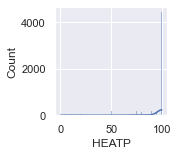

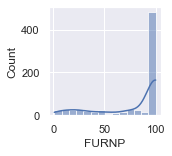

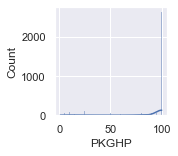

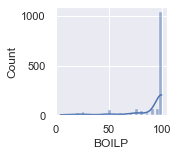

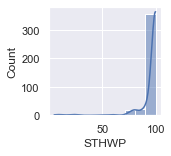

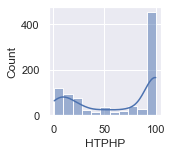

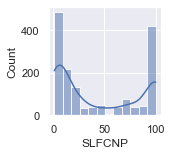

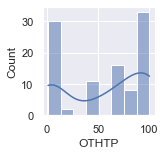

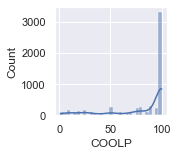

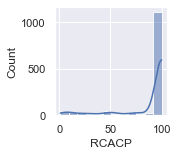

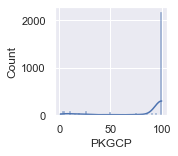

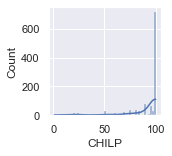

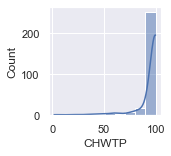

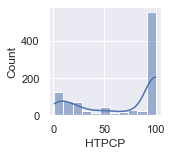

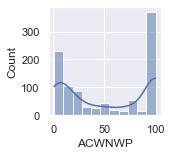

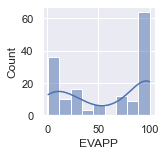

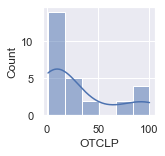

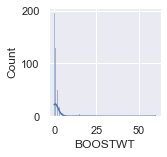

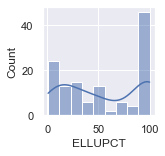

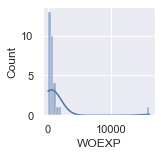

In [25]:
build_hist(num_cols_cat4)

### EDA Category 5

Energy Management

In [26]:
num_cols_cat5 = []
for col in category_dfs[5].columns:
    if col in num_cols:
        num_cols_cat5.append(col)
print(num_cols_cat5)

df5 = category_dfs[5].copy()[num_cols_cat5]
df5_total = df5.shape[0]
print(df5_total)

[]
6720


In [27]:
build_hist(num_cols_cat5)

### EDA Category 6

Service Industry Characteristics - Not right now

In [29]:
num_cols_cat6 = []
for col in category_dfs[6].columns:
    if col in num_cols:
        num_cols_cat6.append(col)
print(num_cols_cat6)

df6 = category_dfs[6].copy()[num_cols_cat6]
df6_total = df6.shape[0]
print(df6_total)

['CONFSPP', 'XRAYN', 'RFGRSN', 'RFGCOMPN', 'RFGWIN', 'RFGOPN', 'RFGCLN', 'RFGVNN', 'RFGICN', 'RFGSTP', 'PCTERMN', 'LAPTPN', 'PRNTRN', 'SERVERN', 'TVVIDEON', 'RGSTRN', 'COPIERN']
6720


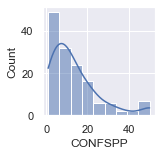

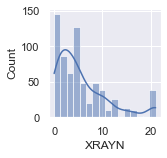

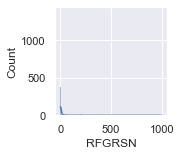

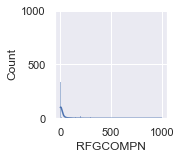

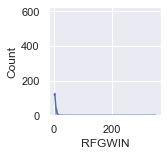

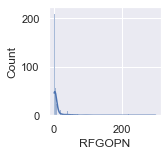

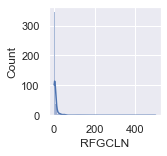

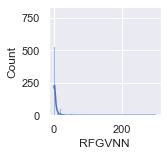

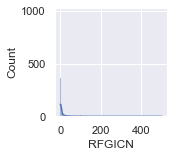

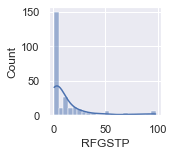

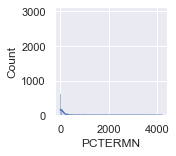

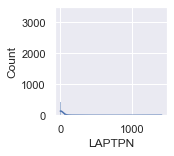

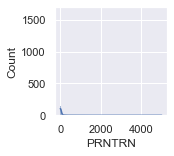

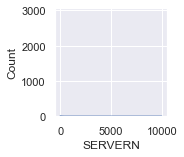

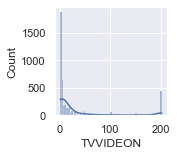

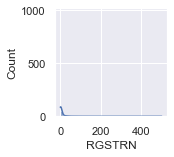

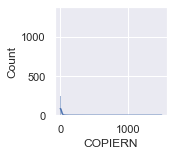

In [30]:
build_hist(num_cols_cat6)

### Category 7

Lighting

In [31]:
num_cols_cat7 = []
for col in category_dfs[7].columns:
    if col in num_cols:
        num_cols_cat7.append(col)
print(num_cols_cat7)

df7 = category_dfs[7].copy()[num_cols_cat7]
df7_total = df7.shape[0]
print(df7_total)

['LTOHRP', 'LTNHRP', 'FLUORP', 'CFLRP', 'BULBP', 'HALOP', 'HIDP', 'LEDP', 'OTLTP', 'DAYLTP']
6720


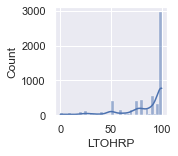

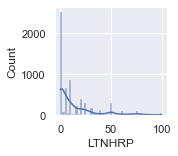

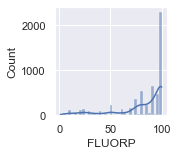

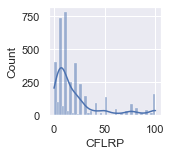

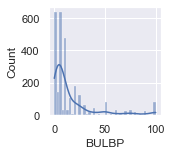

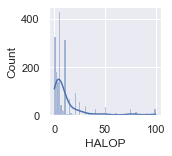

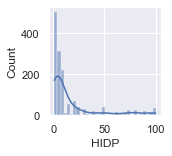

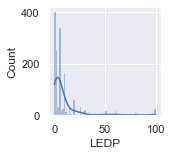

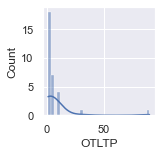

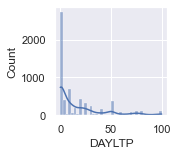

In [32]:
build_hist(num_cols_cat7)

### Category 10

Energy Expenses and Consumption

In [33]:
num_cols_cat10 = []
for col in category_dfs[10].columns:
    if col in num_cols:
        num_cols_cat10.append(col)
print(num_cols_cat10)

df10 = category_dfs[10].copy()[num_cols_cat10]
df10_total = df10.shape[0]
print(df10_total)

['HDD65', 'CDD65', 'MFBTU', 'MFEXP', 'ELCNS', 'ELBTU', 'ELEXP', 'NGCNS', 'NGBTU', 'NGEXP', 'FKCNS', 'FKBTU', 'FKEXP', 'DHCNS', 'DHBTU', 'DHEXP', 'MFHTBTU', 'MFCLBTU', 'MFVNBTU', 'MFWTBTU', 'MFLTBTU', 'MFCKBTU', 'MFRFBTU', 'MFOFBTU', 'MFPCBTU', 'MFOTBTU', 'ELHTBTU', 'ELCLBTU', 'ELVNBTU', 'ELWTBTU', 'ELLTBTU', 'ELCKBTU', 'ELRFBTU', 'ELOFBTU', 'ELPCBTU', 'ELOTBTU', 'NGHTBTU', 'NGCLBTU', 'NGWTBTU', 'NGCKBTU', 'NGOTBTU', 'FKHTBTU', 'FKCLBTU', 'FKWTBTU', 'FKCKBTU', 'FKOTBTU', 'DHHTBTU', 'DHCLBTU', 'DHWTBTU', 'DHCKBTU', 'DHOTBTU']
6720


<ipython-input-8-61d40d949978>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figname)


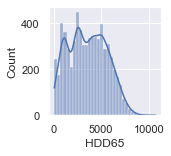

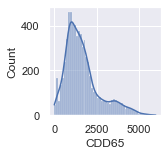

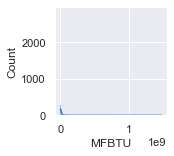

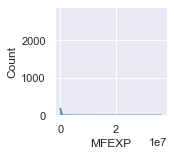

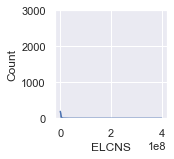

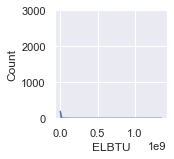

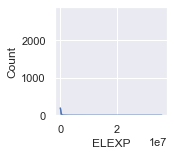

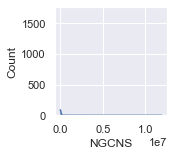

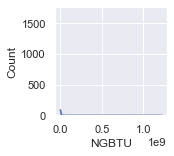

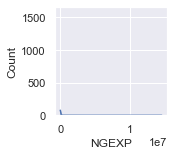

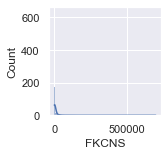

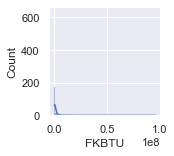

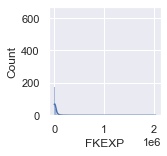

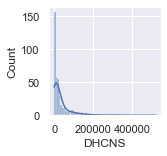

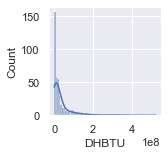

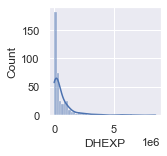

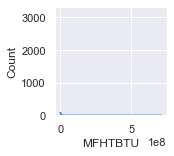

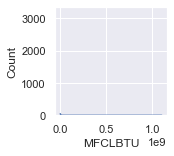

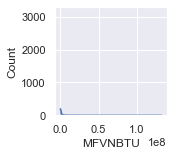

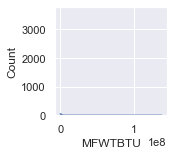

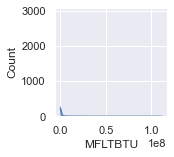

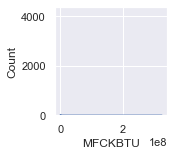

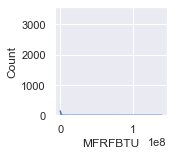

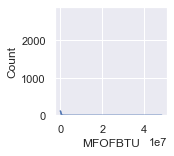

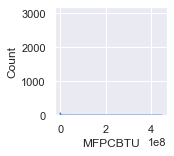

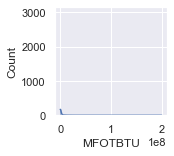

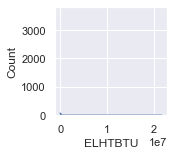

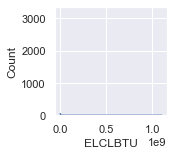

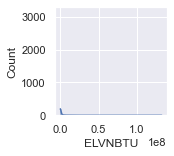

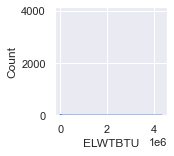

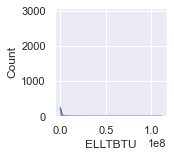

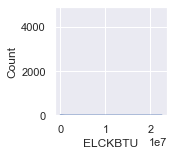

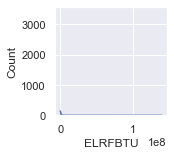

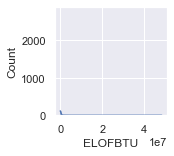

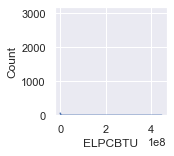

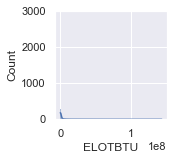

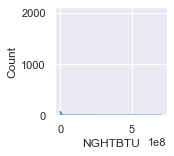

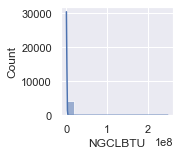

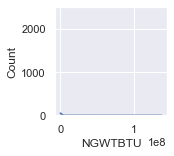

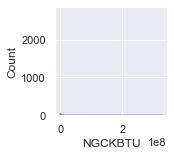

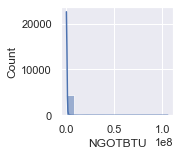

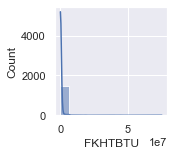

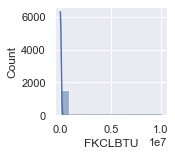

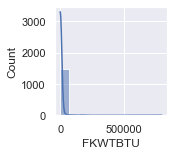

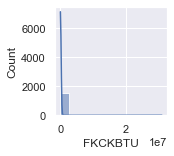

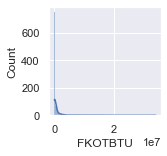

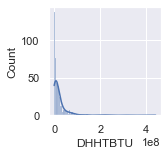

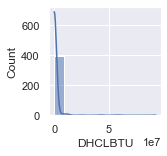

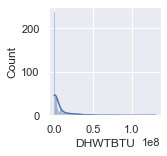

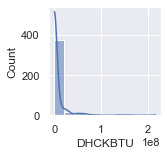

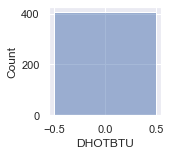

In [34]:
build_hist(num_cols_cat10)